<a href="https://colab.research.google.com/github/MishoK111/ChemiKodi/blob/main/supermarket_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import heapq
import numpy as np

# Generate an exponentially distributed random variable
def exp_rv(rate):
    return np.random.exponential(1.0 / rate)

# Event types
ARRIVAL = 0
DEPARTURE = 1

# Find the index of the shortest queue (least customers)
def shortest_queue(queues):
    return np.argmin([len(q) for q in queues])

# Power-of-two choices strategy: compare two random queues and choose the shorter one
def power_of_two(queues):
    i, j = random.sample(range(len(queues)), 2)  # Pick two random queues
    return i if len(queues[i]) < len(queues[j]) else j

# Randomly select a queue
def random_choice(queues):
    return random.choice(range(len(queues)))

# Main simulation function
def simulate(num_servers, arrival_rate, service_rate, max_time, routing_policy):
    current_time = 0  # Keeps track of simulation time
    event_queue = []  # Priority queue to hold events (arrival/departure)

    # Create a queue for each server
    queues = [[] for _ in range(num_servers)]

    # Schedule the first customer arrival
    heapq.heappush(event_queue, (exp_rv(arrival_rate), ARRIVAL, None))

    # Track the total number of customers and total time spent in the system (sojourn time)
    total_customers = 0
    total_sojourn_time = 0

    # Run the simulation
    while current_time < max_time:
        # Get the next event (arrival or departure) and update the time
        event_time, event_type, server = heapq.heappop(event_queue)
        current_time = event_time

        if event_type == ARRIVAL:
            # A new customer arrives
            total_customers += 1

            # Choose a server according to the specified routing policy
            if routing_policy == 'shortest_queue':
                server = shortest_queue(queues)
            elif routing_policy == 'power_of_two':
                server = power_of_two(queues)
            elif routing_policy == 'random':
                server = random_choice(queues)

            # If the server is idle, serve the customer immediately
            if len(queues[server]) == 0:
                service_time = exp_rv(service_rate)
                heapq.heappush(event_queue, (current_time + service_time, DEPARTURE, server))

            # Add the customer to the selected server's queue
            queues[server].append(current_time)

            # Schedule the next arrival event
            heapq.heappush(event_queue, (current_time + exp_rv(arrival_rate), ARRIVAL, None))

        elif event_type == DEPARTURE:
            # A customer finishes service
            arrival_time = queues[server].pop(0)  # Remove the customer from the queue
            total_sojourn_time += (current_time - arrival_time)

            # If there are more customers in the queue, serve the next one
            if len(queues[server]) > 0:
                service_time = exp_rv(service_rate)
                heapq.heappush(event_queue, (current_time + service_time, DEPARTURE, server))

    # Return the average time spent in the system per customer
    return total_sojourn_time / total_customers

# Compare different routing strategies
def compare_policies(num_servers, arrival_rate, service_rate, max_time):
    policies = ['shortest_queue', 'power_of_two', 'random']
    results = {}

    for policy in policies:
        avg_sojourn_time = simulate(num_servers, arrival_rate, service_rate, max_time, policy)
        results[policy] = avg_sojourn_time

    return results

# Simulation parameters
baseline_arrival_rate = 0.9
num_servers = 5
arrival_rate = baseline_arrival_rate * num_servers
service_rate = 1
max_time = 10000

# Run the simulation and print the results for each routing policy
results = compare_policies(num_servers, arrival_rate, service_rate, max_time)

print("Average sojourn time per customer under different policies:")
for policy, avg_sojourn_time in results.items():
    print(f"{policy}: {avg_sojourn_time:.4f}")

Average sojourn time per customer under different policies:
shortest_queue: 2.9285
power_of_two: 3.0847
random: 10.0755


Agents: 3, Mean Total Cost: $6537.45, 95% CI: ($5936.93, $7137.97)
Agents: 4, Mean Total Cost: $4804.54, 95% CI: ($4205.49, $5403.59)
Agents: 5, Mean Total Cost: $2678.01, 95% CI: ($2052.84, $3303.18)
Agents: 6, Mean Total Cost: $1275.41, 95% CI: ($1091.73, $1459.09)
Agents: 7, Mean Total Cost: $1006.46, 95% CI: ($951.97, $1060.95)
Agents: 8, Mean Total Cost: $1025.38, 95% CI: ($996.01, $1054.74)
Agents: 9, Mean Total Cost: $1113.77, 95% CI: ($1102.48, $1125.06)
Agents: 10, Mean Total Cost: $1211.01, 95% CI: ($1205.33, $1216.69)


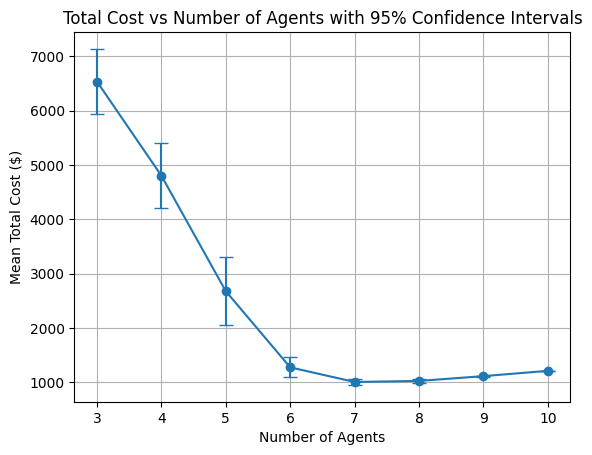

In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def exp_rv(rate):
    return np.random.exponential(1.0 / rate)


ARRIVAL = 0
DEPARTURE = 1


def simulate_call_center(num_agents, arrival_rate, service_rate, staffing_cost_per_hour, waiting_cost_per_minute, simulation_time, num_replications):
    total_costs = []
    for replication in range(num_replications):
        # Initialize the simulation
        current_time = 0.0
        event_queue = []

        # Schedule the first arrival
        arrival_time = exp_rv(arrival_rate)
        heapq.heappush(event_queue, (arrival_time, ARRIVAL))

        # Initialize state variables
        num_in_queue = 0
        wait_times = []
        agent_busy_until = [0.0] * num_agents

        # Customer queue
        customer_queue = []

        while event_queue:
            # Get the next event
            event_time, event_type = heapq.heappop(event_queue)
            if event_time > simulation_time:
                break  # Stop simulation after the simulation time
            current_time = event_time

            if event_type == ARRIVAL:
                # Schedule the next arrival
                next_arrival_time = current_time + exp_rv(arrival_rate)
                heapq.heappush(event_queue, (next_arrival_time, ARRIVAL))

                # Check for an available agent
                available_agent = None
                for i in range(num_agents):
                    if agent_busy_until[i] <= current_time:
                        available_agent = i
                        break

                if available_agent is not None:
                    # Agent is available, start service
                    service_time = exp_rv(service_rate)
                    agent_busy_until[available_agent] = current_time + service_time
                    # Schedule departure
                    heapq.heappush(event_queue, (current_time + service_time, DEPARTURE))
                else:
                    # All agents are busy, customer waits
                    num_in_queue += 1
                    customer_queue.append(current_time)

            elif event_type == DEPARTURE:
                # Check if customers are waiting
                if num_in_queue > 0:
                    num_in_queue -= 1
                    arrival_time_of_customer = customer_queue.pop(0)
                    wait_time = current_time - arrival_time_of_customer
                    wait_times.append(wait_time)
                    # Start service for next customer
                    service_time = exp_rv(service_rate)
                    # Update the agent's busy time
                    for i in range(num_agents):
                        if agent_busy_until[i] <= current_time:
                            agent_busy_until[i] = current_time + service_time
                            break
                    # Schedule departure
                    heapq.heappush(event_queue, (current_time + service_time, DEPARTURE))
                else:
                    # Agent becomes idle
                    pass

        # Calculate total wait time
        total_wait_time = sum(wait_times)  # In seconds

        # Calculate costs
        staffing_cost = num_agents * staffing_cost_per_hour * (simulation_time / 3600.0)  # Convert time to hours
        waiting_cost = (total_wait_time / 60.0) * waiting_cost_per_minute  # Convert time to minutes
        total_cost = staffing_cost + waiting_cost
        total_costs.append(total_cost)

    # Statistical analysis
    mean_total_cost = np.mean(total_costs)
    std_total_cost = np.std(total_costs, ddof=1)
    confidence_level = 0.95
    degrees_freedom = num_replications - 1
    t_crit = np.abs(stats.t.ppf((1 - confidence_level) / 2, degrees_freedom))
    margin_of_error = t_crit * (std_total_cost / np.sqrt(num_replications))
    confidence_interval = (mean_total_cost - margin_of_error, mean_total_cost + margin_of_error)

    return mean_total_cost, confidence_interval, total_costs

# Parameters
arrival_rate = 30 / 3600.0  # Convert to per second
service_rate = 6 / 3600.0   # Convert to per second per agent
staffing_cost_per_hour = 15.0  # $ per agent per hour
waiting_cost_per_minute = 0.50  # $ per customer per minute
simulation_time = 8 * 3600.0  # 8 hours in seconds
num_replications = 30

# Test different numbers of agents
agent_range = range(3, 11)  # From 3 to 10 agents
results = []

for num_agents in agent_range:
    mean_cost, conf_interval, total_costs = simulate_call_center(
        num_agents,
        arrival_rate,
        service_rate,
        staffing_cost_per_hour,
        waiting_cost_per_minute,
        simulation_time,
        num_replications
    )
    results.append({
        'Agents': num_agents,
        'Mean Total Cost': mean_cost,
        '95% CI Lower': conf_interval[0],
        '95% CI Upper': conf_interval[1]
    })
    print(f"Agents: {num_agents}, Mean Total Cost: ${mean_cost:.2f}, 95% CI: (${conf_interval[0]:.2f}, ${conf_interval[1]:.2f})")

# Plot the results
agents = [result['Agents'] for result in results]
mean_costs = [result['Mean Total Cost'] for result in results]
ci_lowers = [mean - result['95% CI Lower'] for mean, result in zip(mean_costs, results)]
ci_uppers = [result['95% CI Upper'] - mean for mean, result in zip(mean_costs, results)]

plt.errorbar(agents, mean_costs, yerr=[ci_lowers, ci_uppers], fmt='o-', capsize=5)
plt.xlabel('Number of Agents')
plt.ylabel('Mean Total Cost ($)')
plt.title('Total Cost vs Number of Agents with 95% Confidence Intervals')
plt.grid(True)
plt.show()
